## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# to handle datasets
import pandas as pd
import numpy as np
import seaborn as sns

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = ['age','fare']
vars_cat = ['sex','cabin','embarked','title',"sibsp","parch","pclass"]
print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 2
Number of categorical variables: 7


In [11]:
#data[vars_cat] = data[vars_cat].to_string()

### Find missing values in variables

In [12]:
# first in numerical variables

null_num_vals = [val for val in vars_num if data[val].isnull().sum()>0]

In [13]:
null_num_vals

['age', 'fare']

In [14]:
# now in categorical variables
null_cat_vals = [val for val in vars_cat if data[val].isnull().sum()>0]


In [15]:
null_cat_vals

['cabin', 'embarked']

### Determine cardinality of categorical variables

In [16]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
sibsp         7
parch         8
pclass        3
dtype: int64

### Determine the distribution of numerical variables

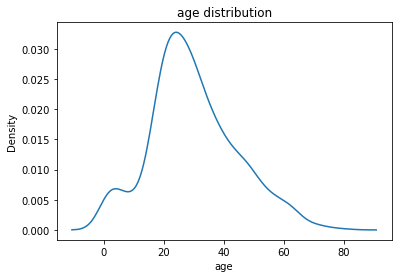

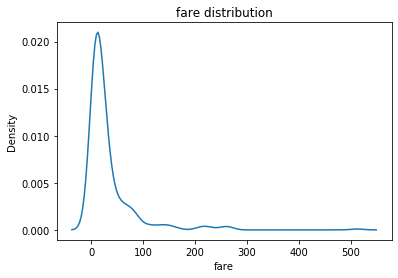

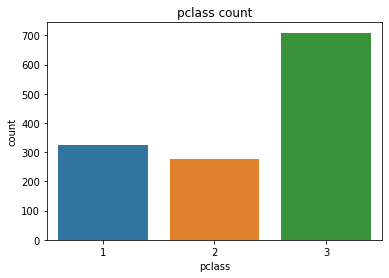

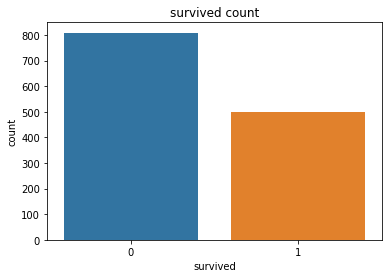

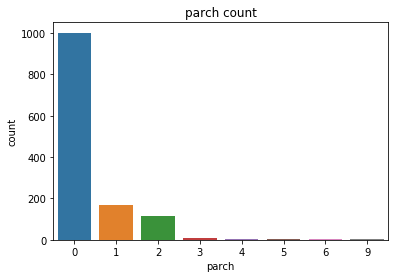

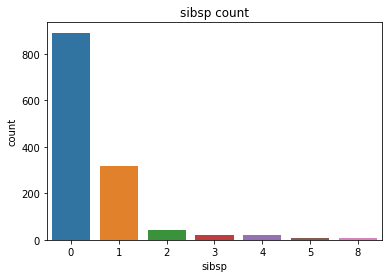

In [17]:
def plot_cont_graph(data, var):
    if data[var].nunique() > 10:
        sns.kdeplot(data=data[var])
    else:
        sns.histplot(data=data[var], bins=data[var].nunique())
    plt.title(f'{var} distribution')
    plt.show()

def plot_num_graph(data, var):
    sns.countplot(data=data, x=var)
    plt.title(f'{var} count')
    plt.show()


for var in vars_num+["pclass","survived","parch","sibsp"]:
    if data[var].dtype == np.float64:
        plot_cont_graph(data, var)
    elif data[var].dtype == np.int64:
        plot_num_graph(data, var)
    else:
        print(f"Skipping {var}: data type {data[var].dtype} not supported.")

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [19]:
# Assign to the 'cabin' column the first letter of the string in that column, if it is not null. Otherwise, assign NaN to the column.
X_train['cabin'] = X_train['cabin'].apply(lambda x: x[0] if pd.notnull(x) else np.nan)
X_test['cabin'] = X_test['cabin'].apply(lambda x: x[0] if pd.notnull(x) else np.nan)

# Count the number of occurrences of each value in the 'cabin' column of the X_train and X_test DataFrames.
print(X_train['cabin'].value_counts())
print(X_test['cabin'].value_counts())

C    78
B    52
D    36
E    36
A    19
F    18
G     4
T     1
Name: cabin, dtype: int64
C    16
B    13
D    10
E     5
A     3
F     3
G     1
Name: cabin, dtype: int64


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [20]:
# For each variable that has missing values
for var in null_num_vals:
    # Calculate the mode of the variable in the X_train set
    mode_val = X_train[var].mode()[0]

    # Add a binary missing indicator column for the variable in both X_train and X_test
    for df in [X_train, X_test]:
        df[var+'_na'] = df[var].isnull().astype(int)

    # Replace missing values with the mode value for the variable in both X_train and X_test
    for df in [X_train, X_test]:
        df[var] = df[var].fillna(mode_val)

# Print the number of missing values for each variable in X_train
print("Number of missing values in X_train:")
print(X_train[null_num_vals].isnull().sum())

Number of missing values in X_train:
age     0
fare    0
dtype: int64


### Replace Missing data in categorical variables with the string **Missing**

In [21]:
X_train[null_cat_vals] = X_train[null_cat_vals].fillna('Missing')
X_test[null_cat_vals] = X_test[null_cat_vals].fillna('Missing')

In [22]:
X_train[null_cat_vals].isnull().sum()

cabin       0
embarked    0
dtype: int64

In [23]:
X_test[null_cat_vals].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [24]:
def freq_labels(df, var, rare_perc):
    # Calculate the threshold for the quantity of rare categories
    rare_threshold = df.shape[0] * rare_perc

    # Find the frequent categories for the specified variable
    value_counts = df[var].value_counts()
    frequent_cats = value_counts[value_counts > rare_threshold].index.tolist()

    # Return a Series containing the values of the variable that are in the frequent categories
    return df.loc[df[var].isin(frequent_cats), var]

In [25]:
for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = freq_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [26]:
X_train['cabin'].value_counts()

Missing    803
Rare       166
C           78
Name: cabin, dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [27]:

X_train[vars_cat].isnull().sum()

sex         0
cabin       0
embarked    0
title       0
sibsp       0
parch       0
pclass      0
dtype: int64

In [28]:
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
sibsp       3
parch       4
pclass      3
dtype: int64

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define the column transformer to encode categorical variables
trans_data = ColumnTransformer(transformers=[
    ('OHEncode', OneHotEncoder(drop='first'), vars_cat)],
    remainder='passthrough')

# Fit the column transformer to the training data and transform it
X_train = trans_data.fit_transform(X_train)

# Transform the test data using the fitted column transformer
X_test = trans_data.transform(X_test)

### Scale the variables

- Use the standard scaler from Scikit-learn

In [30]:
scaler = StandardScaler()
# fit and transform the train set
X_train = scaler.fit_transform(X_train)

# transform the test set using the scaler fitted on train set
X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [31]:


penalty_list = ['l1', 'l2']
tol_list = [0.0001, 0.0005, 0.001]
solver_list = ['liblinear', 'saga']
l1_ratio_list = [0.5, 1]

best_score = 0
best_model = None

# Iterate over all hyperparameter combinations
for penalty in penalty_list:
    for tol in tol_list:
        for solver in solver_list:
            for l1_ratio in l1_ratio_list:
                log_reg = LogisticRegression(penalty=penalty, tol=tol, random_state=0,
                                             solver=solver, l1_ratio=l1_ratio)
                # Fit the model to the training data
                log_reg.fit(X_train, y_train)
                # Calculate the accuracy score on the validation data
                score = log_reg.score(X_test, y_test)
                # If this is the best score we've seen so far, save the model
                if score > best_score:
                    best_score = score
                    best_model = log_reg

# Use the best model to make predictions on the test data
y_pred = best_model.predict(X_test)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [32]:

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.809
ROC-AUC : 0.784


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**